# **CNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/NotAveragePooled/split_features_4s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [5]:
train_data

{'melspectrogram': array([[[2.70414866e-03, 2.79165306e-04, 2.78151976e-06, ...,
          1.06072697e-14, 6.16832790e-08, 5.78963081e-06],
         [2.85087147e-03, 2.95306839e-04, 3.42857310e-06, ...,
          1.12205350e-14, 6.15759939e-08, 5.77909589e-06],
         [3.04498922e-03, 3.15533762e-04, 4.71718391e-06, ...,
          1.25414211e-14, 6.13728398e-08, 5.75930686e-06],
         ...,
         [4.71950382e-06, 6.96979924e-07, 9.83989841e-06, ...,
          1.16200449e-08, 1.17388327e-08, 3.10218327e-07],
         [4.43196142e-06, 4.70733005e-07, 1.06044568e-07, ...,
          1.11483545e-10, 1.11642392e-09, 9.85757182e-08],
         [4.34125244e-06, 4.54310514e-07, 3.83112779e-09, ...,
          1.07090598e-13, 3.56324655e-10, 3.34282947e-08]],
 
        [[1.22058890e-04, 9.34677081e-06, 3.22876749e-15, ...,
          9.62427203e-15, 2.13093339e-07, 5.59486302e-06],
         [1.24266710e-04, 9.51594868e-06, 1.18513276e-14, ...,
          1.10033380e-14, 2.14718425e-07, 5.6383

In [6]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [7]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [8]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [9]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [10]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [11]:
display(train_y.shape)
display(train_y[:15])

(10981,)

array([ 0,  2, 12, 19,  1, 16, 12, 12,  2, 10,  1, 17, 17, 16,  5],
      dtype=int32)

In [12]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(10981, 60, 173)

array([[2.86515150e-03, 6.80767231e-04, 2.97909150e-11, ...,
        1.20800270e-12, 1.54432492e-05, 4.30832110e-04],
       [2.90407872e-03, 6.90050163e-04, 6.33079126e-11, ...,
        9.03021194e-12, 1.60103375e-05, 4.46285096e-04],
       [2.97047890e-03, 7.05829968e-04, 3.58781896e-09, ...,
        4.05444638e-10, 1.69596877e-05, 4.72895689e-04],
       ...,
       [3.84271783e-06, 2.62903578e-06, 3.10762521e-06, ...,
        2.43702737e-06, 9.06983186e-06, 1.78433534e-04],
       [7.97103049e-07, 2.02830843e-07, 2.81801248e-08, ...,
        1.21953893e-08, 5.36466534e-06, 1.55784888e-04],
       [3.61111170e-07, 8.48842786e-08, 2.33122790e-11, ...,
        9.66402053e-12, 5.04421756e-06, 1.46645771e-04]])

'mfcc'

(10981, 20, 173)

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-2.62633655e-02, -3.01888392e-02, -1.81656544e-02, ...,
        -2.21675812e-03,  2.07275861e-03, -4.30428385e-03],
       [-1.18306029e-01, -1.38379296e-01, -1.18820755e-01, ...,
        -1.30277310e-01, -1.29328950e-01, -1.08648978e-01],
       ...,
       [-1.14974521e-02, -8.49716187e-03, -2.17562952e-03, ...,
         3.30199885e-04, -1.76263431e-03,  6.23577901e-04],
       [ 7.35241945e-03,  1.57916311e-02,  1.12288303e-02, ...,
         5.73458393e-03,  1.06985240e-02,  5.53560348e-03],
       [ 7.42952646e-03,  3.86655697e-03,  3.85940464e-03, ...,
        -2.13872632e-05,  9.07076072e-03,  5.01042272e-03]])

'chroma'

(10981, 12, 173)

array([[0.49322796, 0.55023208, 0.99232902, ..., 0.72210309, 0.83299871,
        0.63234777],
       [1.        , 1.        , 1.        , ..., 0.94905946, 0.97092678,
        0.57756803],
       [0.71974691, 0.88993172, 0.96673663, ..., 1.        , 1.        ,
        0.87034696],
       ...,
       [0.37971051, 0.70089198, 0.86866288, ..., 0.73178094, 0.69199241,
        0.96665332],
       [0.31718219, 0.57008808, 0.98001273, ..., 0.5537603 , 0.65570829,
        0.87120081],
       [0.32763275, 0.44132466, 0.99494184, ..., 0.5402766 , 0.98134254,
        1.        ]])

'rms'

(10981, 1, 173)

array([[0.00039074, 0.00042852, 0.0004804 , 0.00054854, 0.00058784,
        0.00059393, 0.00059617, 0.00046273, 0.00041349, 0.00041963,
        0.00041193, 0.00041588, 0.00042323, 0.000566  , 0.00061378,
        0.00074525, 0.00152645, 0.00249982, 0.00342579, 0.01243992,
        0.01289345, 0.01355664, 0.01639647, 0.01172002, 0.01117699,
        0.01018599, 0.00364752, 0.0012906 , 0.00091503, 0.00064468,
        0.00050603, 0.0004332 , 0.00041633, 0.00040445, 0.00039667,
        0.00039603, 0.00039678, 0.00040109, 0.00052812, 0.00073974,
        0.00167491, 0.00551012, 0.01040052, 0.02760901, 0.02811749,
        0.02768876, 0.02625788, 0.00595194, 0.00222059, 0.00113607,
        0.00076726, 0.00063663, 0.00062657, 0.00285686, 0.01670538,
        0.01927643, 0.02217778, 0.02311721, 0.01691305, 0.01483164,
        0.01245705, 0.01647372, 0.02695421, 0.03781732, 0.04618729,
        0.04510737, 0.03964701, 0.02910161, 0.00945323, 0.00467422,
        0.00572438, 0.02610471, 0.03316663, 0.03

In [13]:
display(val_y.shape)
display(val_y[:15])

(2928,)

array([ 1,  0,  3, 13, 15,  7,  0, 11, 17, 18, 10,  0,  1,  2,  2],
      dtype=int32)

In [14]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(2928, 60, 173)

array([[3.32319924e-06, 3.85627327e-07, 1.62118227e-13, ...,
        8.35242172e-13, 1.47860481e-04, 2.38549490e-03],
       [3.39569346e-06, 3.94667132e-07, 2.45596577e-13, ...,
        1.36000466e-12, 1.49738668e-04, 2.41649617e-03],
       [3.52569295e-06, 4.10863971e-07, 8.27563479e-12, ...,
        1.52835391e-11, 1.53004160e-04, 2.47022787e-03],
       ...,
       [4.70026294e-07, 7.63783576e-08, 2.50398643e-08, ...,
        1.18084688e-07, 8.87401461e-06, 1.05132121e-04],
       [3.93884604e-07, 4.36421482e-08, 1.52936053e-10, ...,
        5.23465998e-10, 5.83651537e-06, 9.45892576e-05],
       [3.64246105e-07, 4.02502116e-08, 1.24587951e-13, ...,
        1.86082433e-13, 5.47833371e-06, 8.88705570e-05]])

'mfcc'

(2928, 20, 173)

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-0.05321965, -0.09204954, -0.10380825, ..., -0.14202162,
        -0.02764694,  0.03943524],
       [-0.45512561, -0.54788593, -0.54157671, ..., -0.56502541,
        -0.44753002, -0.31922681],
       ...,
       [-0.02174164, -0.02651668, -0.04083253, ..., -0.04537298,
        -0.02602495, -0.01727532],
       [ 0.01664417,  0.02065739,  0.00117265, ..., -0.00260825,
         0.0099968 ,  0.02472534],
       [-0.01499395, -0.01298963,  0.0023331 , ..., -0.0144565 ,
        -0.0206337 , -0.02124815]])

'chroma'

(2928, 12, 173)

array([[0.02405424, 0.03210343, 0.07836496, ..., 0.01892673, 0.25222963,
        0.35473842],
       [0.10054196, 0.21368316, 0.40564924, ..., 0.02409197, 0.34999723,
        0.50214092],
       [0.1580866 , 0.14295156, 0.09562304, ..., 0.01910207, 0.36193931,
        0.58541331],
       ...,
       [0.03860641, 0.02437317, 0.02632891, ..., 0.24834281, 0.73819415,
        0.66448111],
       [0.01557225, 0.01391101, 0.03290793, ..., 0.12710531, 0.6942014 ,
        0.57520359],
       [0.02324896, 0.02448379, 0.04552641, ..., 0.02347876, 0.39079534,
        0.40234969]])

'rms'

(2928, 1, 173)

array([[0.02225015, 0.02555211, 0.0265466 , 0.02252608, 0.01568867,
        0.02629739, 0.02896822, 0.0435867 , 0.04932851, 0.04663459,
        0.04794999, 0.03810471, 0.05818411, 0.07532492, 0.07372992,
        0.07230121, 0.05424416, 0.0222149 , 0.02307186, 0.02486459,
        0.02186136, 0.03875333, 0.05505793, 0.06267009, 0.06324769,
        0.05314591, 0.03477944, 0.01649618, 0.01746471, 0.01886477,
        0.02194129, 0.023644  , 0.02064178, 0.01911475, 0.02065624,
        0.02115975, 0.02198245, 0.02571904, 0.02157723, 0.01782953,
        0.02261083, 0.02795133, 0.03256924, 0.04175666, 0.03936617,
        0.03579794, 0.04168303, 0.03811065, 0.04565651, 0.04389921,
        0.03450453, 0.03074298, 0.0218442 , 0.03266475, 0.03377284,
        0.03713641, 0.03521169, 0.0367388 , 0.03605549, 0.03023931,
        0.0293515 , 0.01836588, 0.0236658 , 0.02847057, 0.02899235,
        0.02746851, 0.02799471, 0.02754326, 0.02959297, 0.02768993,
        0.02191872, 0.02211438, 0.0183103 , 0.03

## **CNN Model**

In [15]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2]), name='Audio_Features')

  # add first convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=32,
              kernel_size=3,
              strides=1,
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(inputs)

  # add first max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

  # add second convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=64,
              kernel_size=3,
              strides=1,
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(features)

  # add second max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=512,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.2)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [16]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [17]:
train_results = {}
val_results = {}

### **With all the features**

In [18]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(10981, 93, 173)

In [19]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(2928, 93, 173)

Fit the model with training data

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 93, 173)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 93, 32)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 787,284 (3.00 MB)

 Trainable params: 787,284 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1754 - loss: 4.5608 - weighted_accuracy: 0.1754 - val_accuracy: 0.2695 - val_loss: 3.8963 - val_weighted_accuracy: 0.2695
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3343 - loss: 3.7085 - weighted_accuracy: 0.3343 - val_accuracy: 0.2848 - val_loss: 3.5716 - val_weighted_accuracy: 0.2848
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4017 - loss: 3.2457 - weighted_accuracy: 0.4017 - val_accuracy: 0.3419 - val_loss: 3.2977 - val_weighted_accuracy: 0.3419
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4577 - loss: 2.9132 - weighted_accuracy: 0.4577 - val_accuracy: 0.3473 - val_loss: 3.1599 - val_weighted_accuracy: 0.3473
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4959 - loss: 2.6507 - weighted_accuracy: 0.4959 - val_accuracy: 0.3542 - val_loss: 3.0605 - val_weighted_accuracy: 0.3542
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

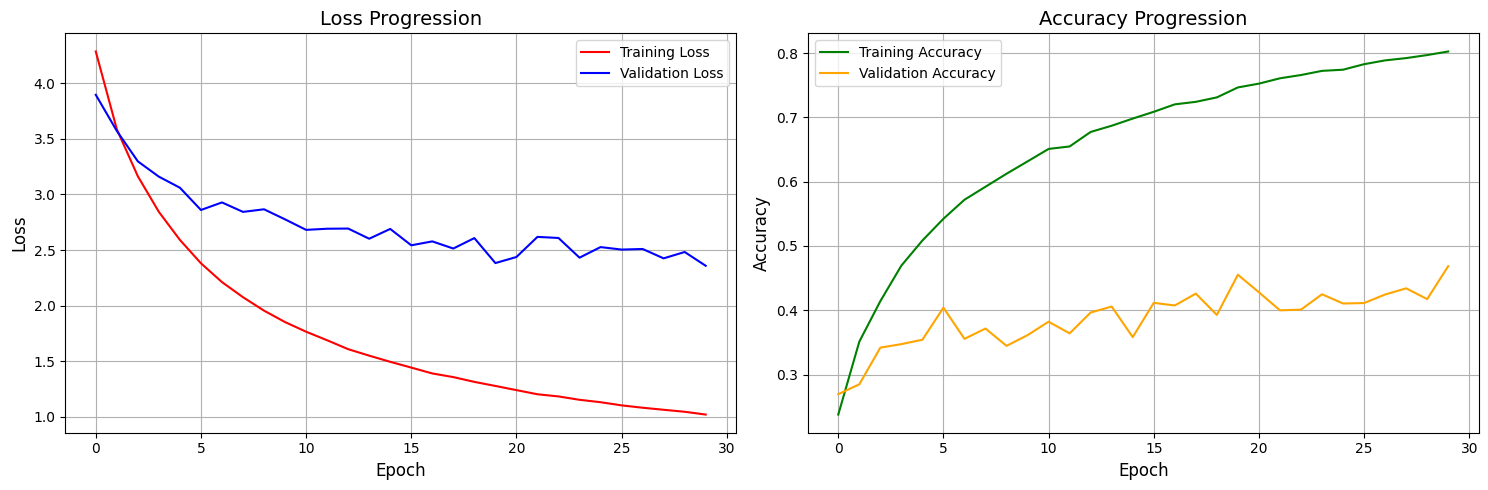

In [20]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [21]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8330 - loss: 0.9466 - weighted_accuracy: 0.8330
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4677 - loss: 2.3136 - weighted_accuracy: 0.4677


## **With MFCCs and Mel-Spectrogram**

In [22]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(10981, 80, 173)

In [23]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(2928, 80, 173)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 80, 173)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 80, 32)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688,980 (2.63 MB)

 Trainable params: 688,980 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1842 - loss: 4.5623 - weighted_accuracy: 0.1842 - val_accuracy: 0.2893 - val_loss: 3.8311 - val_weighted_accuracy: 0.2893
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3553 - loss: 3.6050 - weighted_accuracy: 0.3553 - val_accuracy: 0.3388 - val_loss: 3.4172 - val_weighted_accuracy: 0.3388
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4334 - loss: 3.0895 - weighted_accuracy: 0.4334 - val_accuracy: 0.3460 - val_loss: 3.2049 - val_weighted_accuracy: 0.3460
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4986 - loss: 2.7047 - weighted_accuracy: 0.4986 - val_accuracy: 0.4027 - val_loss: 2.9445 - val_weighted_accuracy: 0.4027
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5347 - loss: 2.4304 - weighted_accuracy: 0.5347 - val_accuracy: 0.3470 - val_loss: 2.9047 - val_weighted_accuracy: 0.3470
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

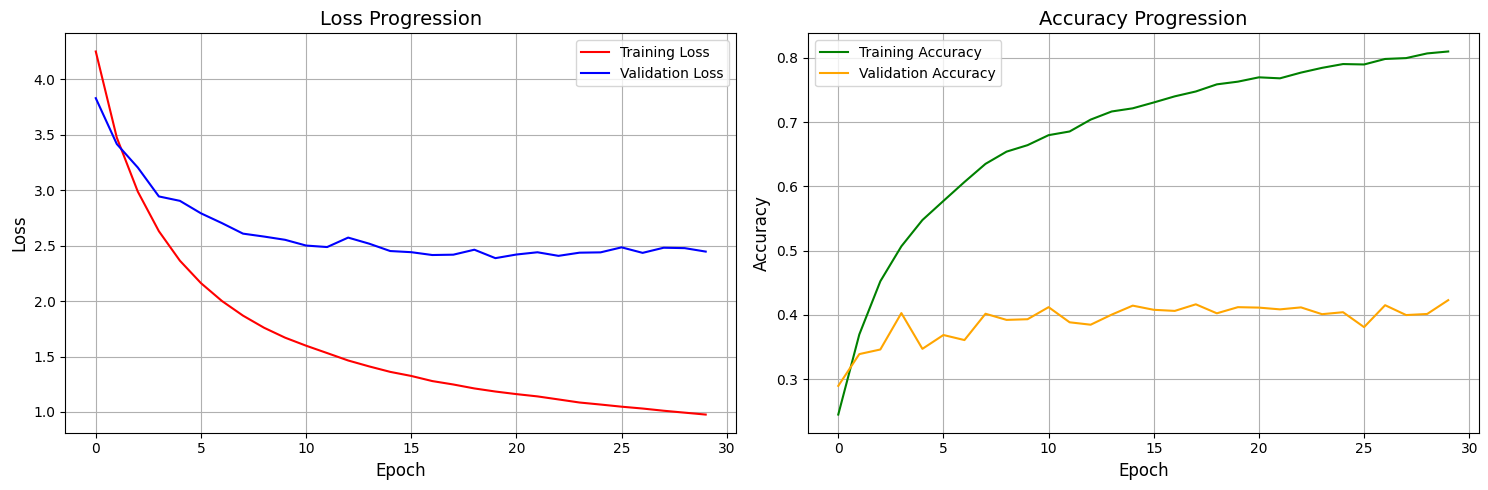

In [24]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [25]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8002 - loss: 1.0804 - weighted_accuracy: 0.8002
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4034 - loss: 2.3589 - weighted_accuracy: 0.4034


## **With Mel-Spectrogram, MFCCs, RMS**

In [26]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(10981, 81, 173)

In [27]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(2928, 81, 173)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 81, 173)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 81, 32)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 40, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 40, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 688,980 (2.63 MB)

 Trainable params: 688,980 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1864 - loss: 4.5078 - weighted_accuracy: 0.1864 - val_accuracy: 0.3067 - val_loss: 3.8734 - val_weighted_accuracy: 0.3067
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3556 - loss: 3.6674 - weighted_accuracy: 0.3556 - val_accuracy: 0.3764 - val_loss: 3.4769 - val_weighted_accuracy: 0.3764
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4283 - loss: 3.1760 - weighted_accuracy: 0.4283 - val_accuracy: 0.3702 - val_loss: 3.2617 - val_weighted_accuracy: 0.3702
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4772 - loss: 2.8251 - weighted_accuracy: 0.4772 - val_accuracy: 0.3719 - val_loss: 3.1185 - val_weighted_accuracy: 0.3719
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5343 - loss: 2.5536 - weighted_accuracy: 0.5343 - val_accuracy: 0.3453 - val_loss: 3.0720 - val_weighted_accuracy: 0.3453
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

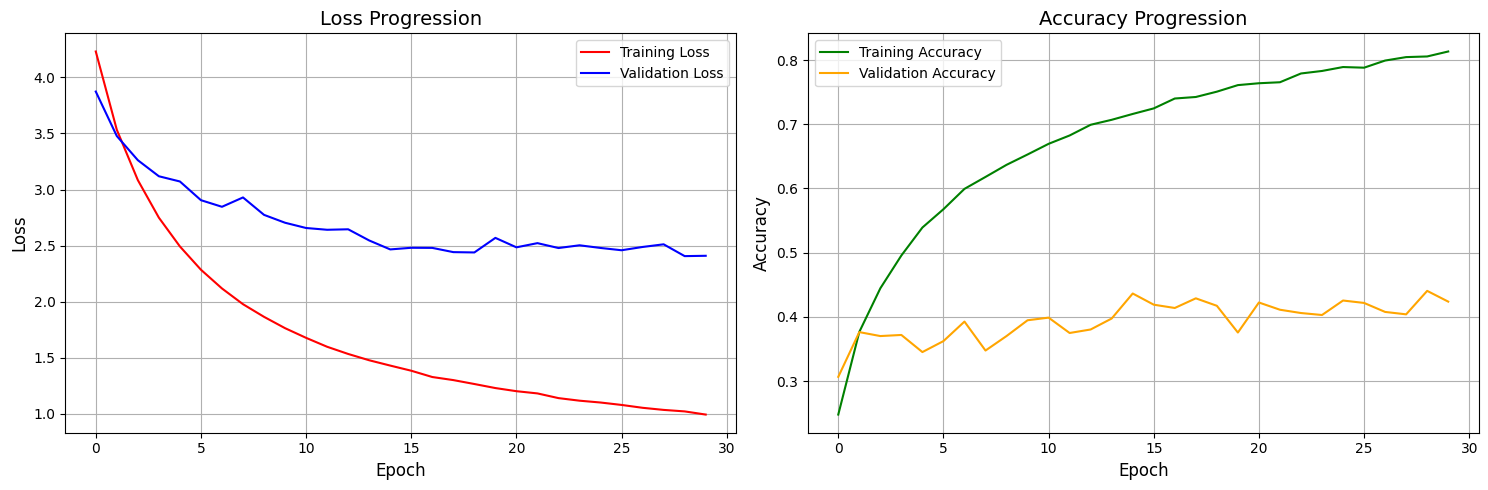

In [28]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [29]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8375 - loss: 0.9313 - weighted_accuracy: 0.8375
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4358 - loss: 2.3649 - weighted_accuracy: 0.4358


## **With Mel-Spectrogram, MFCCs, Chroma**

In [30]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(10981, 92, 173)

In [31]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(2928, 92, 173)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 92, 173)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 92, 32)              │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling1D)                │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling1D)                │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1472)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 512)                 │         754,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 787,284 (3.00 MB)

 Trainable params: 787,284 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1859 - loss: 4.5695 - weighted_accuracy: 0.1859 - val_accuracy: 0.2633 - val_loss: 3.9044 - val_weighted_accuracy: 0.2633
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3349 - loss: 3.7196 - weighted_accuracy: 0.3349 - val_accuracy: 0.3214 - val_loss: 3.6044 - val_weighted_accuracy: 0.3214
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4162 - loss: 3.2670 - weighted_accuracy: 0.4162 - val_accuracy: 0.3583 - val_loss: 3.3458 - val_weighted_accuracy: 0.3583
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4719 - loss: 2.9241 - weighted_accuracy: 0.4719 - val_accuracy: 0.3870 - val_loss: 3.2059 - val_weighted_accuracy: 0.3870
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5007 - loss: 2.6797 - weighted_accuracy: 0.5007 - val_accuracy: 0.3719 - val_loss: 3.0539 - val_weighted_accuracy: 0.3719
Epoch 6/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

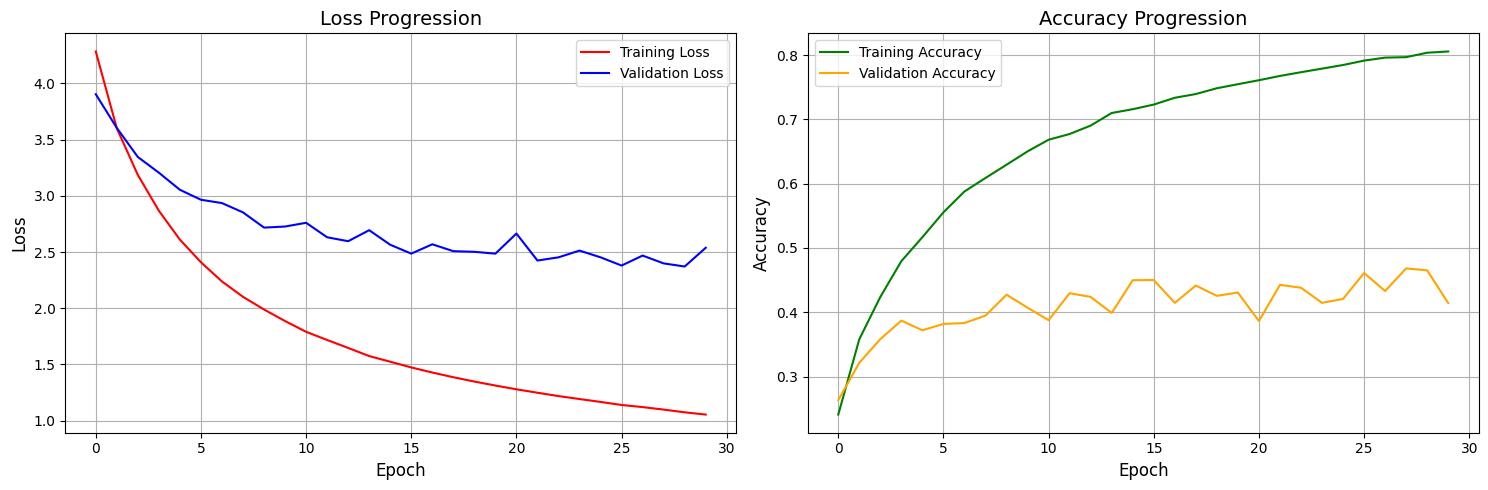

In [32]:
model = build_model(training_features)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=30,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1,
    callbacks=[callback]
)

best_epoch = history.history['val_weighted_accuracy'].index(max(history.history['val_weighted_accuracy']))
print('best_epoch: ', best_epoch)
visualize(history)

In [33]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8332 - loss: 0.9821 - weighted_accuracy: 0.8332
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 2.3333 - weighted_accuracy: 0.4643


# Review results from all models

In [34]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.83,0.47
3,melspectrogram_chroma_mfcc,0.83,0.47
2,melspectrogram_rms_mfcc,0.84,0.44
1,mfcc_melspectrogram,0.80,0.41
